## Analyzing keio plate 3

This notebook runs the analysis pipeline for the preliminary data for Keio plate 3.

In [1]:
#Import packages
import numpy as np 
import os
import tifffile as tiff
from skimage.io import imread
from skimage.measure import label, regionprops
import scipy
import matplotlib.pyplot as plt
import cPickle as pickle
from SLIP_functions import analyze_well, analyze_plate, segment_SLIP, plot_slip_well, plot_slip_wells
from SLIP_functions import plot_slip_joint_plot, fit_kde, compute_p_values
from SLIP_functions import classify_infections, compute_p_lysis_posterior, compute_MOI_posterior
from keio_names import get_keio_names, pos_to_strain
import seaborn as sns
import pandas as pd
import pymc3 as pm

sns.set_context('notebook', font_scale = 1.1)
sns.set_style('white')
sns.set_style('ticks')

#Activate matplotlib inline
%matplotlib inline

#Define root directory path
root_direc = '/media/vanvalen/fe0ceb60-f921-4184-a484-b7de12c1eea6/keio_screen/07.13.2017/keio_3/'
plate_number = 3

#Define directory path to infection data (all positions)
data_direc = os.path.join(root_direc, 'data')

#Define directory path to control data (all positions)
control_direc = os.path.join(root_direc, 'control')

#Define directory path to where you want to store neural net outputs. 
#mask directories must exist at run time!
mask_direc = os.path.join(root_direc, 'masks')
control_mask_direc = os.path.join(root_direc,'control_masks')

tifffile.py:156: UserWarning: failed to import the optional _tifffile C extension module.
Loading of some compressed images will be slow.
Tifffile.c can be obtained at http://www.lfd.uci.edu/~gohlke/
  "failed to import the optional _tifffile C extension module.\n"
Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5005)


In [2]:
#Define which wells were used
row_control = ['A']
col_control = [1]

row_data = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
col_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [3]:
#Load saved data
mean_FITC_name = os.path.join(root_direc, 'mean_FITC.pkl')
mean_cherry_name = os.path.join(root_direc, 'mean_cherry.pkl')
mean_FITC = pickle.load(open(mean_FITC_name, 'rb'))
mean_cherry = pickle.load(open(mean_cherry_name, 'rb'))

mean_FITC_control_name = os.path.join(root_direc, 'mean_FITC_control.pkl')
mean_cherry_control_name = os.path.join(root_direc, 'mean_cherry_control.pkl')
mean_FITC_control = pickle.load(open(mean_FITC_control_name, 'rb'))
mean_cherry_control = pickle.load(open(mean_cherry_control_name, 'rb'))

p_values_dict_name = os.path.join(root_direc, 'p_values_dict.pkl')
p_values_dict = pickle.load(open(p_values_dict_name, 'rb'))

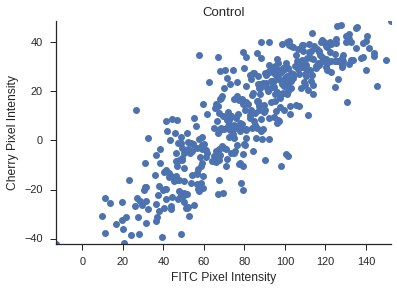

In [4]:
#Plot the data from the control plate
plot_slip_well(mean_FITC_control, mean_cherry_control, well = 'A1', title = 'Control')
sns.despine()

/home/vanvalen/.pyenv/versions/2.7.4/envs/DeepCell/lib/python2.7/site-packages/openpyxl/reader/worksheet.py:310: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


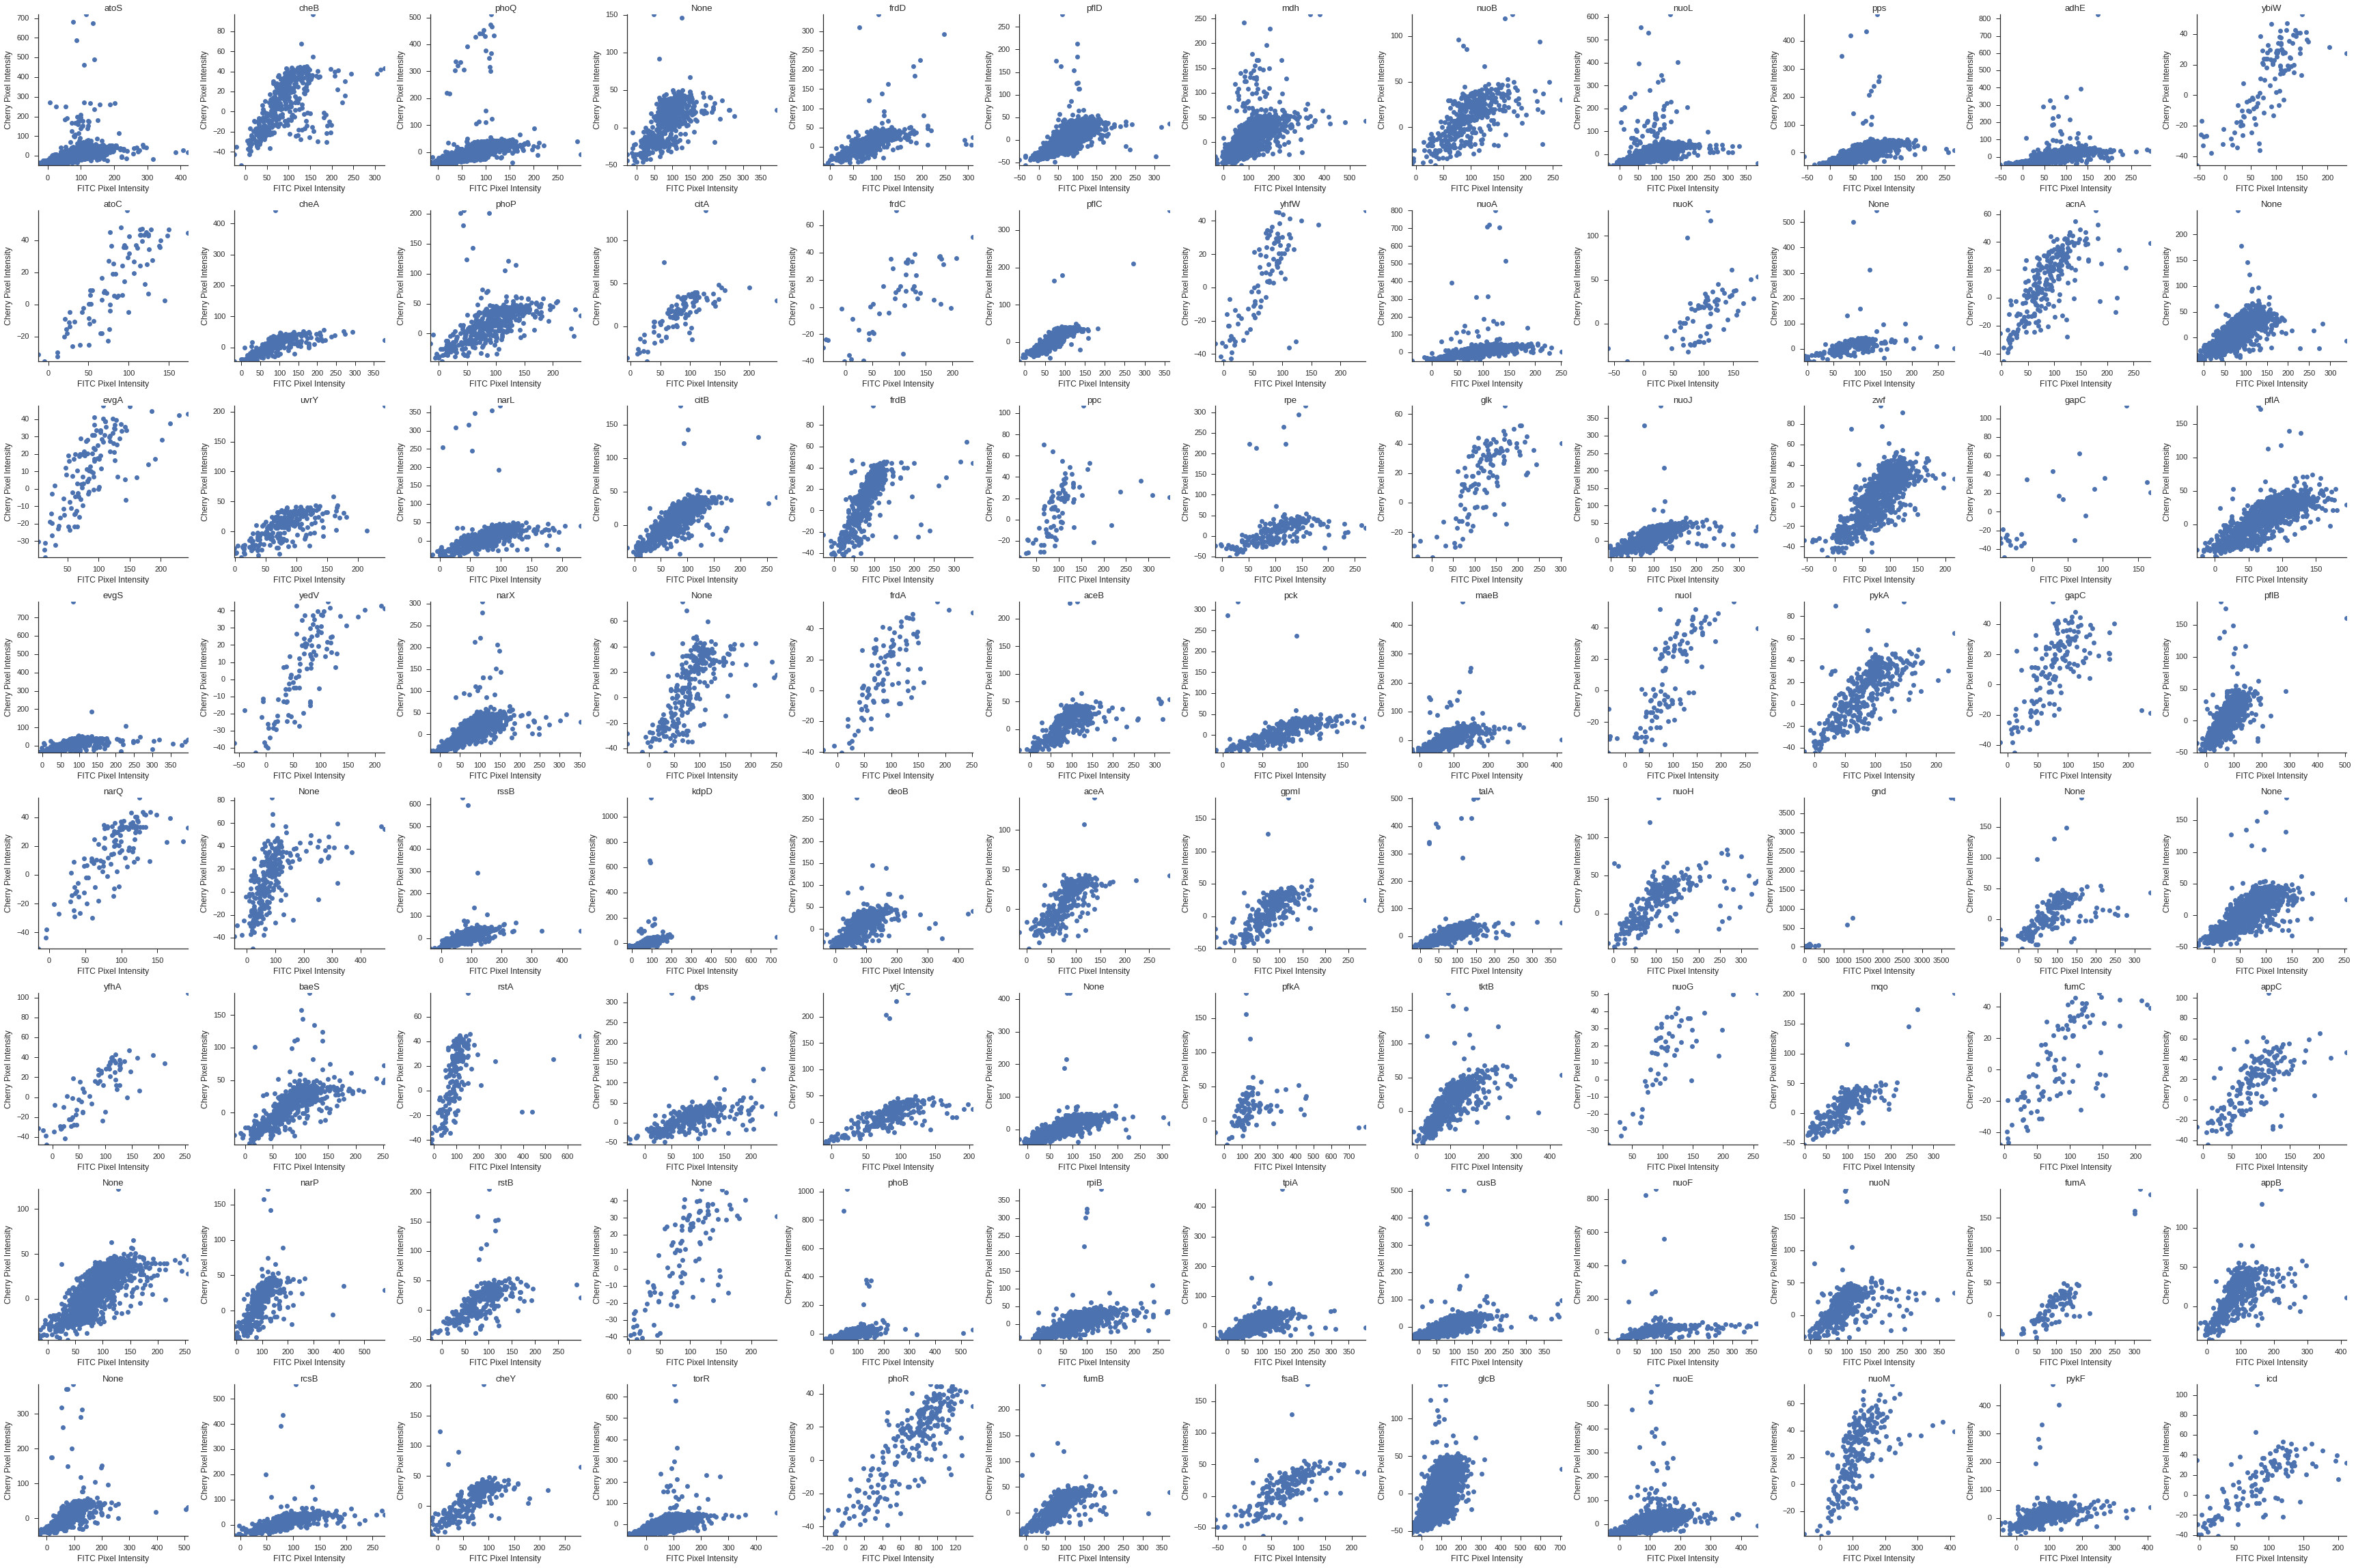

In [5]:
#Plot the scatter plot of intensities
wells = []
titles = []
keio_names_array = get_keio_names()

for row in row_data:
    for col in col_data:
        well = row + str(col)
        wells += [well]
        titles += [pos_to_strain(keio_names_array, 3, well)]
        
plot_slip_wells(mean_FITC, mean_cherry, wells = wells, titles = titles)
sns.despine()

In [6]:
#Print the number of cells in each well
for key in mean_FITC_control.keys():
    print key, len(mean_FITC_control[key])
    
for key in mean_FITC.keys():
    print key, len(mean_FITC[key])

A1 447
G7 1207
G6 871
G5 548
G4 107
G3 262
G2 447
G1 1175
G9 485
G8 1487
B4 108
B5 50
B6 348
B7 95
B1 84
B2 343
B3 462
B8 1030
B9 73
E9 269
E8 604
E5 762
E4 724
E7 264
E6 298
E1 118
E3 910
E2 261
H10 227
H11 597
H12 125
F12 174
F10 242
F11 98
H8 4204
H9 3233
H2 587
H3 271
H1 719
H6 571
H7 209
H4 6522
H5 259
D10 382
D11 152
D12 987
B12 1449
B10 205
B11 247
C9 830
C8 119
C3 532
C2 242
C1 126
C7 213
C6 88
C5 431
C4 599
G12 465
G11 101
G10 411
F1 73
F2 557
F3 178
F4 334
F5 244
F6 691
F7 101
F8 599
F9 54
E11 195
E10 189
E12 1293
C12 907
C11 26
C10 815
A11 1706
A10 1033
A12 115
A1 3814
A3 2071
A2 437
A5 586
A4 570
A7 1911
A6 2030
A9 2338
A8 437
D8 892
D9 116
D6 369
D7 348
D4 267
D5 100
D2 103
D3 1162
D1 543


In [7]:
# Fit a KDE estimator to the no infection control
kernel = fit_kde(mean_FITC_control, mean_cherry_control, 'A1')

In [8]:
#Compute the fraction infected in each well and plot
conc_list = []
fraction_infected_list = []
for well in p_values_dict.keys():
    p_value = p_values_dict[well]
    fraction_infected = np.float(np.where(p_value < 0.01)[0].shape[0])/np.float(p_value.shape[0])
    fraction_infected_list += [fraction_infected]
    
    print well, fraction_infected

G7 0.056338028169
G6 0.0723306544202
G5 0.107664233577
G4 0.0934579439252
G3 0.118320610687
G2 0.127516778523
G1 0.0782978723404
G9 0.171134020619
G8 0.0773369199731
B4 0.0648148148148
B5 0.2
B6 0.0229885057471
B7 0.0210526315789
B1 0.047619047619
B2 0.116618075802
B3 0.147186147186
B8 0.1
B9 0.164383561644
E9 0.197026022305
E8 0.0745033112583
E5 0.0695538057743
E4 0.0483425414365
E7 0.0492424242424
E6 0.0335570469799
E1 0.0508474576271
E3 0.0505494505495
E2 0.134099616858
H10 0.281938325991
H11 0.157453936348
H12 0.112
F12 0.109195402299
F10 0.0909090909091
F11 0.0918367346939
H8 0.0892007611798
H9 0.149087534797
H2 0.105621805792
H3 0.0405904059041
H1 0.0973574408901
H6 0.0823117338004
H7 0.105263157895
H4 0.0515179392824
H5 0.0
D10 0.0680628272251
D11 0.0592105263158
D12 0.0405268490375
B12 0.0621118012422
B10 0.0926829268293
B11 0.080971659919
C9 0.1
C8 0.319327731092
C3 0.0507518796992
C2 0.0495867768595
C1 0.0714285714286
C7 0.201877934272
C6 0.147727272727
C5 0.0394431554524
C4 

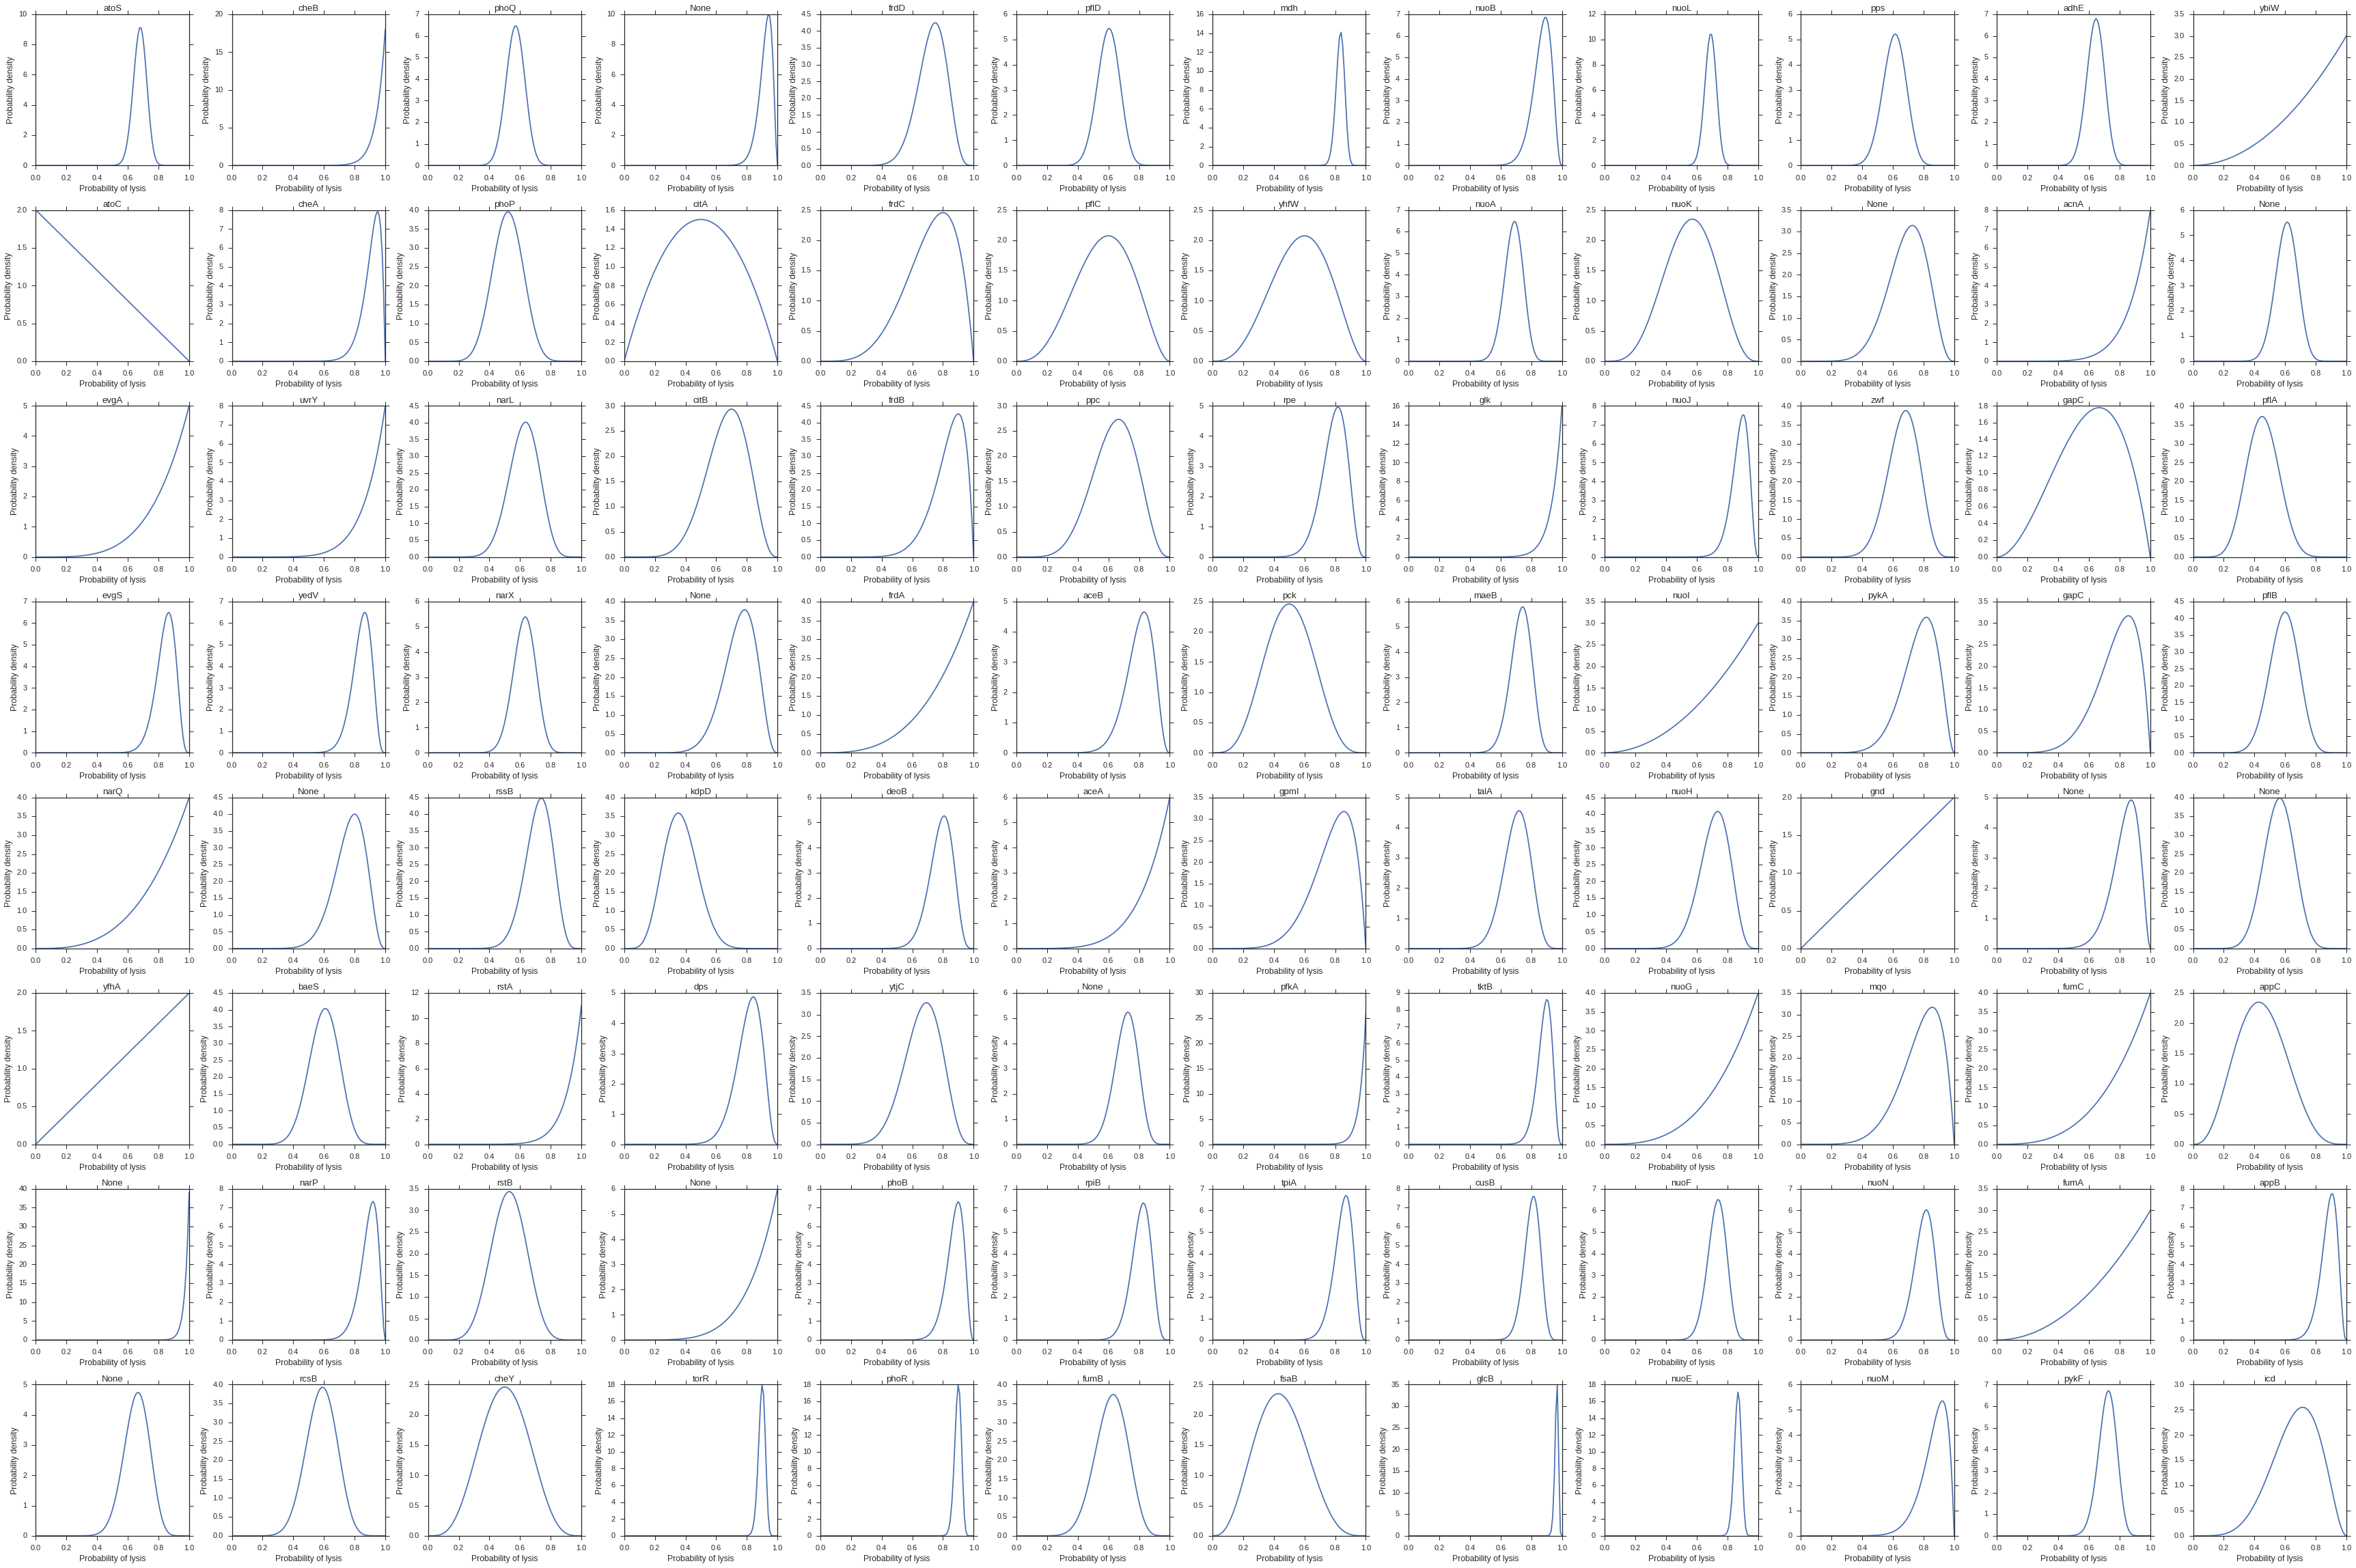

In [10]:
# Use the no phage control to construct a lysis/lysogeny classifier
fitc_control_array = np.array(mean_FITC_control['A1'])
cherry_control_array = np.array(mean_cherry_control['A1'])
kernel_fitc = scipy.stats.gaussian_kde(fitc_control_array)
kernel_cherry = scipy.stats.gaussian_kde(cherry_control_array)

def compute_p_lysis_posterior(N_lysis, N_lysogeny):
    x = np.linspace(0,1,100)
    posterior= scipy.stats.beta.pdf(x, 1+N_lysis, 1+N_lysogeny)
    return x, posterior

# d = classify_infections(kernel_fitc, kernel_cherry, p_values_dict, rows = row_data, cols = col_data)

kn = get_keio_names()
fig, axes = plt.subplots(8,12, figsize = (4*12, 4*8))

for row in row_data:
    for col in col_data:
        well = row + str(col)
        
        well_name = pos_to_strain(kn, plate = plate_number, pos = well)
        p_value = p_values_dict[well]
        infected_cells = np.where(p_value < 0.01)[0]
        fitc_list = np.array(mean_FITC[well])[infected_cells]
        cherry_list = np.array(mean_cherry[well])[infected_cells]

        p_fitc = []
        p_cherry = []
        for fitc, cherry in zip(fitc_list, cherry_list):
            p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
            p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

        # Remove double positives
        p_fitc_new = []
        p_cherry_new = []
        fitc_list_new = []
        cherry_list_new = []
        for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
            if (p_f < 0.85 and c > 50) or p_c < 0.85:
                p_fitc_new += [p_f]
                p_cherry_new += [p_c]
                fitc_list_new += [f]
                cherry_list_new += [c]

        p_fitc = p_fitc_new
        p_cherry = p_cherry_new
        fitc_list = fitc_list_new
        cherry_list = cherry_list_new

        d = {'FITC Probability': p_fitc, 'Cherry Probability': p_cherry}
        dataframe = pd.DataFrame(data = d)
#         grid = sns.lmplot('FITC Probability', 'Cherry Probability', dataframe, fit_reg = False)
#         ax = grid.axes[0][0]
#         ax.set_title(well_name)
#         ax.set_xlim([-0.05, 1.05])
#         ax.set_ylim([-0.05, 1.05])

        d = {'FITC Intensity': fitc_list, 'Cherry Intensity': cherry_list}
        dataframe = pd.DataFrame(data = d)
#         grid = sns.lmplot('FITC Intensity', 'Cherry Intensity', dataframe, fit_reg = False, scatter_kws = {'color': 'red'})
#         ax = grid.axes[0][0]
#         ax.set_title(well_name)

        counter = 0
        for p_f, p_c in zip(p_fitc, p_cherry):
            if p_f > p_c:
                counter += 1
                
        if len(p_fitc) > 0:
            #Uncomment to print p_lysis
            #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
            
            x, posterior = compute_p_lysis_posterior(counter, len(p_fitc) - counter)
            
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('Probability of lysis')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
        else:    
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('Probability of lysis')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
            
plt.tight_layout()
    

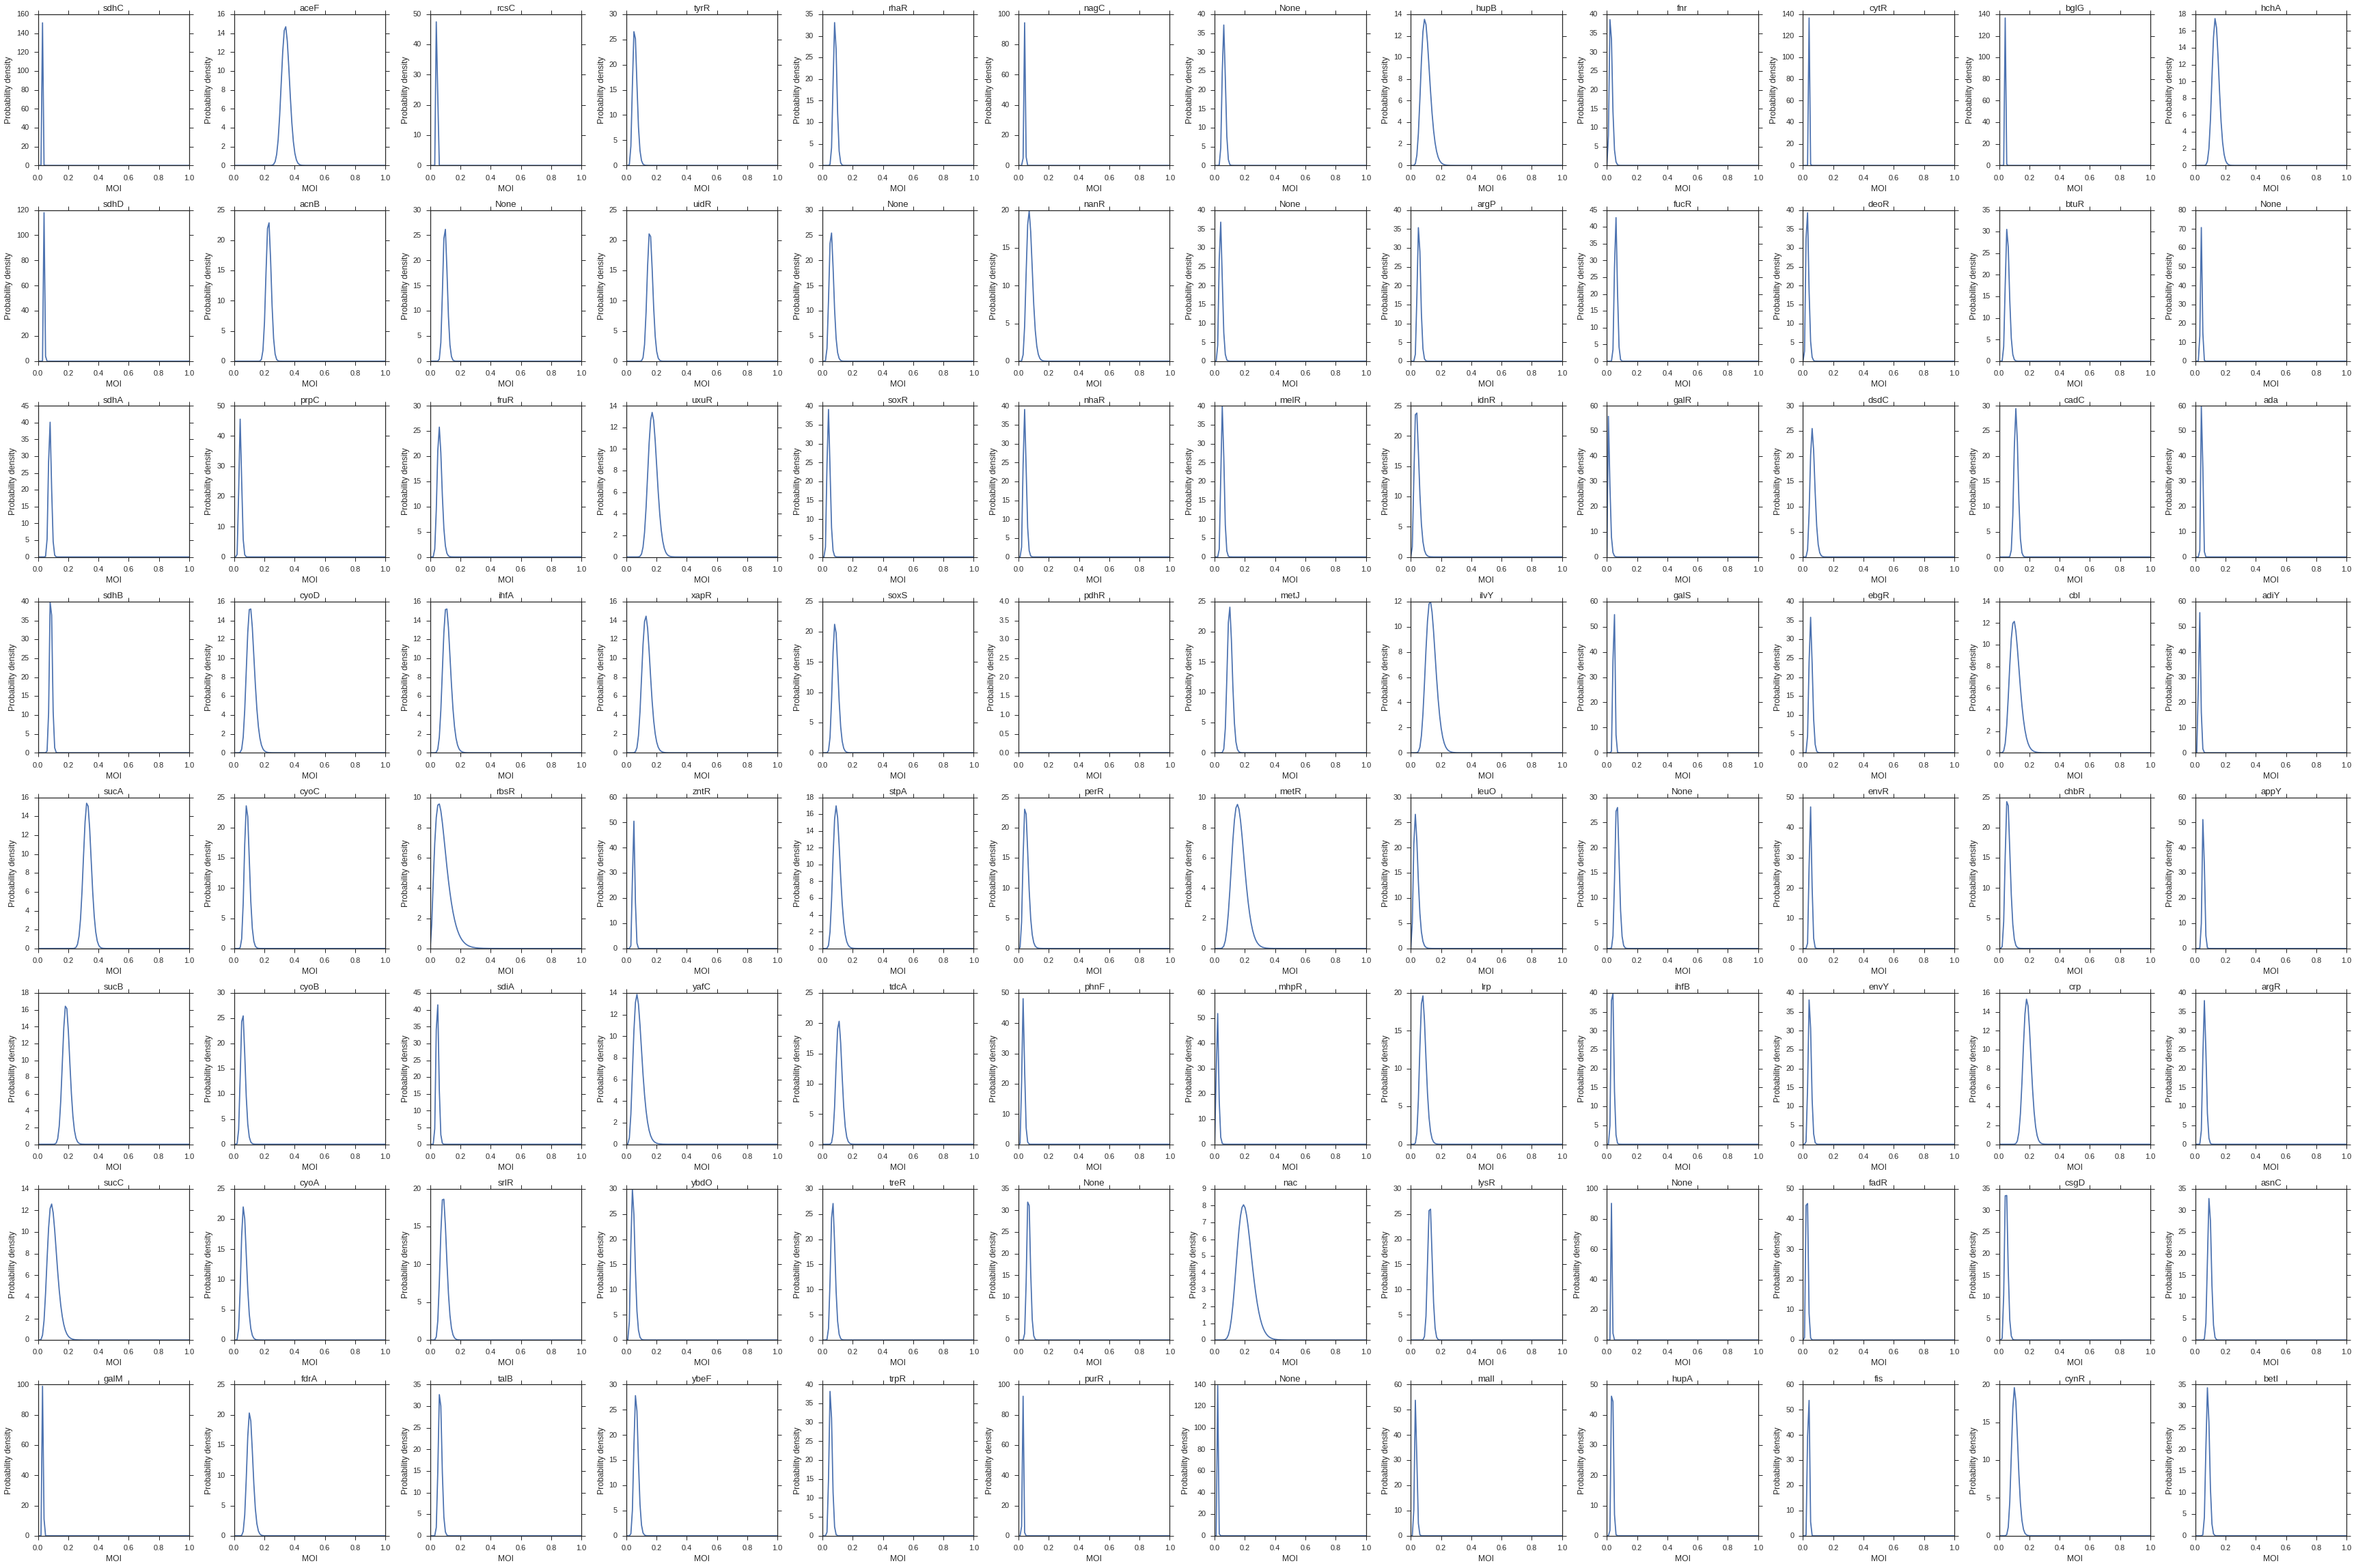

In [10]:
fig, axes = plt.subplots(8,12, figsize = (4*12, 4*8))

def compute_inverse_MOI_posterior(N_infected, N_cells):
    x = np.linspace(0,2,200)
    gamma = np.float(N_cells)*np.log(1-1/np.float(N_cells))
    posterior = np.abs(gamma*np.exp(gamma*x))*scipy.stats.beta.pdf(np.exp(gamma*x), 1+N_cells-N_infected, 1+N_infected)

    return x, posterior

kn = get_keio_names()

for row in row_data:
    for col in col_data:
        well = row + str(col)
        
        well_name = pos_to_strain(kn, plate = plate_number, pos = well)
        p_value = p_values_dict[well]
        infected_cells = np.where(p_value < 0.01)[0]
        fitc_list = np.array(mean_FITC[well])[infected_cells]
        cherry_list = np.array(mean_cherry[well])[infected_cells]

        p_fitc = []
        p_cherry = []
        for fitc, cherry in zip(fitc_list, cherry_list):
            p_fitc += [1-kernel_fitc.integrate_box_1d(fitc, 1e6)]
            p_cherry += [1-kernel_cherry.integrate_box_1d(cherry, 1e6)]

        # Remove double positives
        p_fitc_new = []
        p_cherry_new = []
        fitc_list_new = []
        cherry_list_new = []
        for p_f, p_c, f, c in zip(p_fitc, p_cherry, fitc_list, cherry_list):
            if (p_f < 0.85 and c > 50) or p_c < 0.85:
                p_fitc_new += [p_f]
                p_cherry_new += [p_c]
                fitc_list_new += [f]
                cherry_list_new += [c]

        p_fitc = p_fitc_new
        p_cherry = p_cherry_new
        fitc_list = fitc_list_new
        cherry_list = cherry_list_new

        counter = 0
        for p_f, p_c in zip(p_fitc, p_cherry):
            if p_f > p_c:
                counter += 1
                
        if len(p_fitc) > 0:
            #Uncomment to print p_lysis
            #print well_name, np.float(counter)/len(p_fitc), counter, len(p_fitc)
            x, posterior = compute_inverse_MOI_posterior(infected_cells.shape[0], p_value.shape[0])
            
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('MOI')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
        else:    
            alphabet = ['A','B','C','D','E','F','G','H']
            chars = list(well)
            row_temp = alphabet.index(chars[0])
            if len(chars) == 2:
                col_temp = int(chars[1])-1
            if len(chars) == 3:
                col_temp = int(chars[1] + chars[2])-1
                
            axes[row_temp, col_temp].plot(x, posterior)
            axes[row_temp, col_temp].set_xlim([0, 1])
            axes[row_temp, col_temp].set_xlabel('MOI')
            axes[row_temp, col_temp].set_ylabel('Probability density')
            axes[row_temp, col_temp].set_title(well_name)
            
plt.tight_layout()